<a href="https://colab.research.google.com/github/csabiu/ML_tutorial/blob/master/sdss_2pcf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook will guide you through a realistic analysis of galaxy survey data.
We will download real data and then measure its 2-point correlation function.
We will make a theoretical prediction of the 2-point correlaiton function and compare with that of the observation.

In [1]:
import scipy
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
plt.rcParams.update({'font.size': 15})


Install CAMB for theory prediction \\
Install KSTAT for making measurement

In [2]:
!pip install camb
!git clone https://github.com/csabiu/kstat.git

     |████████████████████████████████| 1.6 MB 5.1 MB/s 
  Created wheel for camb: filename=camb-1.3.2-py3-none-any.whl size=1009274 sha256=5f3037c05cb969918780cf64a3c7995b33fde38bc595441b6e1456383ee0df2b
  Stored in directory: /root/.cache/pip/wheels/d3/c1/34/87632240be4218d112bc9b47c18e92ef81bfb6bc1e1f0f0a72
Successfully built camb
Cloning into 'kstat'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 38 (delta 1), reused 1 (delta 0), pack-reused 30
Unpacking objects: 100% (38/38), done.


Make KSTAT manually

In [3]:
output = os.system("cd kstat/src; make ; cd ../../")

### Download SDSS eBOSS DR12 CMASS data and random catalogs
search in https://data.sdss.org/sas/ for other catalogues if you want to try a different target eg, ELG, QSO - or even newer eBOSS data!

In [4]:
!wget https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASS_South.fits.gz
!wget https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASS_South.fits.gz

--2021-10-29 06:37:15--  https://data.sdss.org/sas/dr12/boss/lss/galaxy_DR12v5_CMASS_South.fits.gz
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31, 2001:1948:414:13::31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51580500 (49M) [application/octet-stream]
Saving to: ‘galaxy_DR12v5_CMASS_South.fits.gz’

galaxy_DR12v5_CMASS 100%[===================>]  49.19M  22.0MB/s    in 2.2s    

2021-10-29 06:37:17 (22.0 MB/s) - ‘galaxy_DR12v5_CMASS_South.fits.gz’ saved [51580500/51580500]

--2021-10-29 06:37:17--  https://data.sdss.org/sas/dr12/boss/lss/random0_DR12v5_CMASS_South.fits.gz
Resolving data.sdss.org (data.sdss.org)... 155.101.19.31, 2001:1948:414:13::31
Connecting to data.sdss.org (data.sdss.org)|155.101.19.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1172229517 (1.1G) [application/octet-stream]
Saving to: ‘random0_DR12v5_CMASS_South.fits.gz’

random0_DR12v5_CM

### Extract relavent columns from the fits file
Angular positions (RA, dec), redshift (z) and weights

In [5]:
hdul = fits.open('galaxy_DR12v5_CMASS_South.fits.gz')
ra=hdul[1].data['RA']
dec=hdul[1].data['DEC']
z=hdul[1].data['Z']
wtot=hdul[1].data['WEIGHT_SYSTOT']
wcp=hdul[1].data['WEIGHT_CP']
wnoz=hdul[1].data['WEIGHT_NOZ']
wfkp=hdul[1].data['WEIGHT_FKP']
wgal=wtot*wfkp*(wcp+wnoz-1.0) #Eq 2 from https://arxiv.org/pdf/1607.03154.pdf


### Plot the redshift distribution

mean redshift of the galaxies : 0.5426714


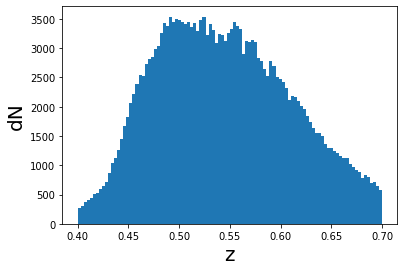

In [8]:
ind=np.where((z>0.4) & (z<0.7)) #cut the redshift range
plt.hist(z[ind],100)
plt.xlabel('z',fontsize=20)
plt.ylabel('dN',fontsize=20)
print("mean redshift of the galaxies :",np.mean(z))

Text(0, 0.5, 'dec')

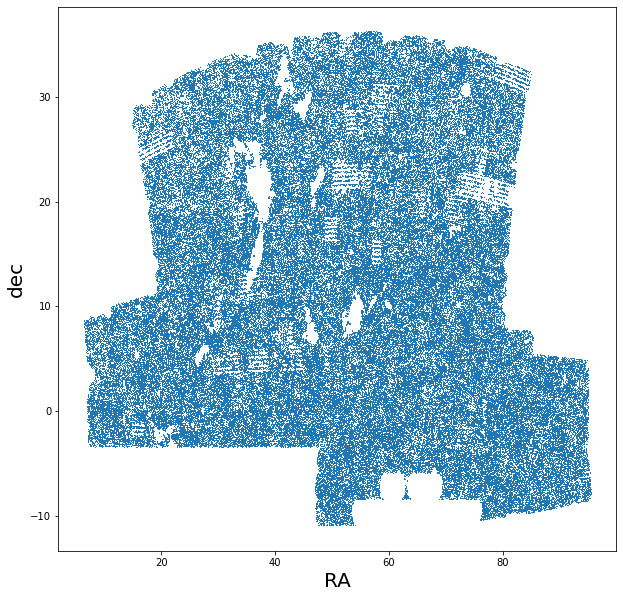

In [9]:
plt.figure(figsize=(10,10))
plt.plot(np.mod(ra+50,360),dec,',')
plt.xlabel('RA',fontsize=20)
plt.ylabel('dec',fontsize=20)

## Use astropy to convert from angle and redshift to cartesean comoving x,y,z positions

In [10]:
from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
from astropy.coordinates import SkyCoord

ind=np.where((z>0.4) & (z<0.7))
cosmo=FlatLambdaCDM(Om0=0.31,Ob0=0.022,H0=100) # sets the cosmological model working in units Mpc/h with Ho=100
dist=cosmo.comoving_distance(z[ind]).value  # convert redshift to distance

c = SkyCoord(ra=ra[ind]*u.degree, dec=dec[ind]*u.degree, distance=dist*u.Mpc) # convert to x,y,z
data=np.transpose((c.cartesian.x,c.cartesian.y,c.cartesian.z, wgal[ind]))
np.savetxt("gal.txt",data) # save file 

### Load the Random Catalogue and repeat the same proceedure 

In [11]:
hdul = fits.open('random0_DR12v5_CMASS_South.fits.gz')
ra=hdul[1].data['RA']
dec=hdul[1].data['DEC']
z=hdul[1].data['Z']
wrand=hdul[1].data['WEIGHT_FKP']

mean redshift of the randoms : 0.5433296495801546


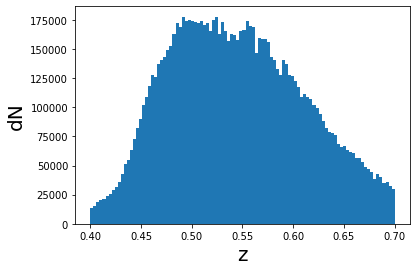

In [12]:
ind=np.where((z>0.4) & (z<0.7))
plt.hist(z[ind],100)
plt.xlabel('z',fontsize=20)
plt.ylabel('dN',fontsize=20)
print("mean redshift of the randoms :",np.mean(z))

Plotting the random point angular positions we see that they look almostly exactly like the galaxies as they should

Text(0, 0.5, 'dec')

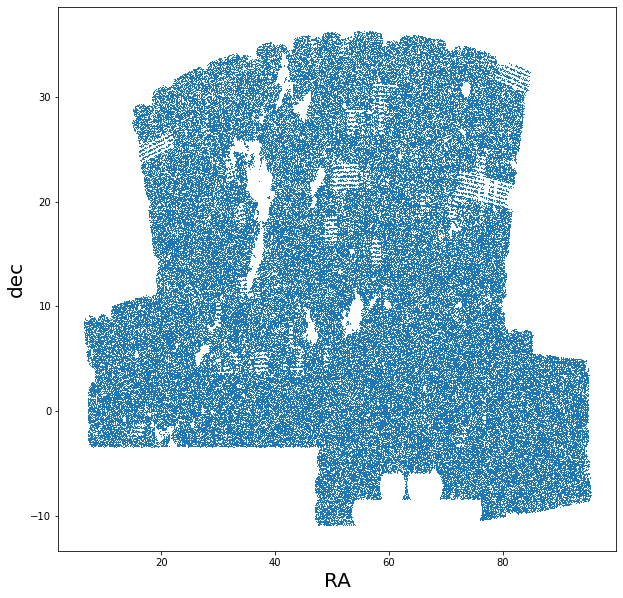

In [13]:
plt.figure(figsize=(10,10))
plt.plot(np.mod(ra[::50]+50,360),dec[::50],',') # plot a random sample 1/50
plt.xlabel('RA',fontsize=20)
plt.ylabel('dec',fontsize=20)

In [14]:
dist=cosmo.comoving_distance(z[ind]).value

c = SkyCoord(ra=ra[ind]*u.degree, dec=dec[ind]*u.degree, distance=dist*u.Mpc)
data=np.transpose((c.cartesian.x,c.cartesian.y,c.cartesian.z, wrand[ind]))
np.savetxt("ran.txt",data[::50,:]) # save a subsample of data (1/50)

## Run my KSTAT code (~1 min)
20 measurement bins logarithmically spaced between 1 and 60 Mpc

In [31]:
!kstat/bin/2pcf -gal gal.txt -ran ran.txt -rmin 1.0 -rmax 60.0 -nbins 20 -log .true. -wgt .true.

 Using logarithmic binning scheme
 Using weighted points.
  I will calculate the statistical covariance
  I will read the data for covariance
  Using          125  resamples for the statistical covariance.
 Preparing to read       213205 data points
 Preparing to read       214868 random points
 opening gal.txt.jk
 Finished reading data file 1
 opening ran.txt.jk
 Finished reading data file 2
 max resmaple:         125
 min resmaple:           1
  building tree on node           0
  built tree on node           0
 Calculating the isotropic 3D correlation function
   1.0000000000000000        1.2271780044536826     
   1.2271780044536826        1.5059658546149226     
   1.5059658546149226        1.8480881722417255     
   1.8480881722417255        2.2679331552660544     
   2.2679331552660544        2.7831576837137404     
   2.7831576837137404        3.4154298923797612     
   3.4154298923797612        4.1913404396820519     
   4.1913404396820519        5.1435207967550411     
   5.1

Load and plot the result file

In [18]:
!head -1 result.txt # the columns of the result file 

R_min, R_max, DD, DR, RR, XI_natural, XI_Davis, XI_LS (most accurate)


Text(0, 0.5, '$\\xi$')

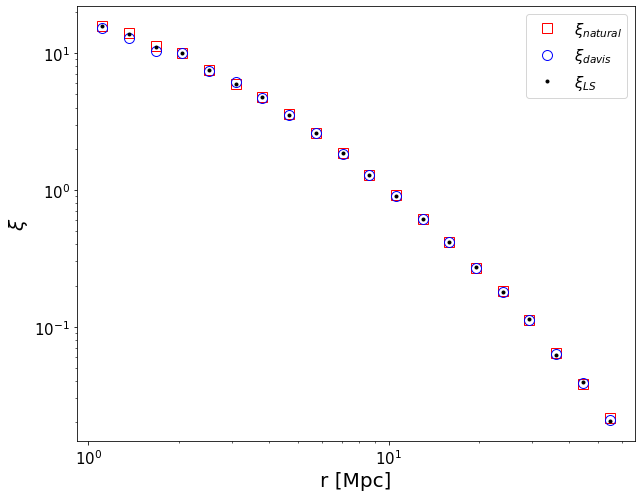

In [19]:
x=np.loadtxt('result.txt',skiprows=1)

xi_natural=x[:,5]
xi_davis=x[:,6]
xi_LS=x[:,7]
s=np.mean(x[:,0:2],axis=1)

plt.rcParams.update({'font.size': 15})

plt.figure(figsize=(10,8))
plt.loglog(s,xi_natural,'rs',markerfacecolor='none', ms=10,label=r'$\xi_{natural}$')
plt.loglog(s,xi_davis,'bo',markerfacecolor='none', ms=10,label=r'$\xi_{davis}$')
plt.loglog(s,xi_LS,'k.',label=r'$\xi_{LS}$')

plt.legend()
plt.xlabel('r [Mpc]',fontsize=20)
plt.ylabel(r'$\xi$',fontsize=20)

### Lets start to make the theory prediction with CAMB

In [15]:
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /usr/local/lib/python3.7/dist-packages/camb


### This is how you set up an instance of CAMB for the matter power spectrum with a particular cosmology 

In [75]:
kmax=100          # maximum k range
k_per_logint = 10  # number of points per log interval
zs = [0.55]        # redshift (mean of the galaxy sample) 

pars = camb.CAMBparams()
pars.set_cosmology(H0=68.0, ombh2=0.022, omch2=0.12) 
pars.InitPower.set_params(ns=0.965,As=2.0905e-09)
pars.WantTransfer = True
pars.set_matter_power(redshifts=zs, kmax=kmax, k_per_logint=k_per_logint, silent=True)
results = camb.get_results(pars)


PKint = results.get_matter_power_interpolator(nonlinear=True, 
    hubble_units=True, k_hunit=True)

### Lets plot the power spectrum

Text(0, 0.5, '$P(k)$')

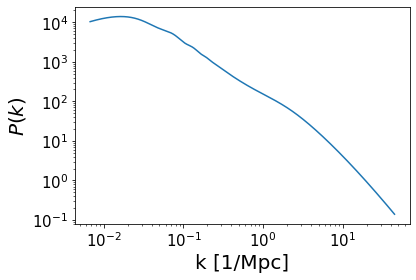

In [81]:
kh_nonlin=np.exp(np.arange(-5.0,3.8,0.0001)) # set k steps
pk_nonlin=PKint.P(0.55, kh_nonlin)           # get P at those k and reshift z of sample
plt.loglog(kh_nonlin,pk_nonlin,'-')

plt.xlabel('k [1/Mpc]',fontsize=20)
plt.ylabel(r'$P(k)$',fontsize=20)

Need to numerically integrate $$ \xi(r)=\frac{1}{2\pi^2}\int k^2P(k) j_0 dk$$

use trapz function to numerically integrate over the integrand which is just product of 1-D arrays - for smooth integrands with enough samples trapz is usually accurate enough

In [18]:
bias=2.2 #galaxy bias parameter

xi=[]
rr=np.arange(1,60,2)  # set range in r scale Mpc/h
for r in rr:
    xi.append(bias**2*np.trapz(kh_nonlin**2*pk_nonlin*np.sin(kh_nonlin*r)/(kh_nonlin*r),kh_nonlin)/(2*np.pi**2) )

Text(0, 0.5, '$\\xi$')

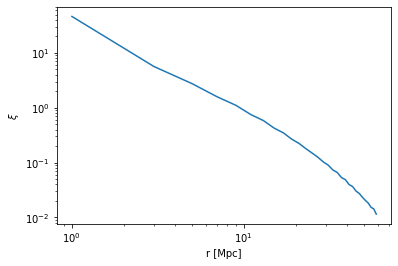

In [19]:
plt.loglog(rr,xi)

plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi$')

### Plot the theory and data together

Text(0, 0.5, '$\\xi$')

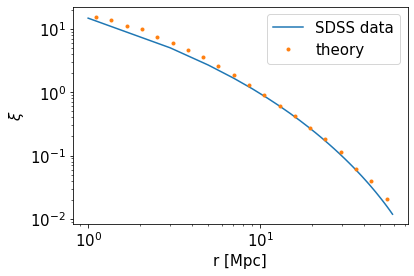

In [33]:
plt.loglog(rr,xi,'-',label='SDSS data')
plt.loglog(s,xi_LS,'.',label='theory')

plt.legend()
plt.xlabel('r [Mpc]')
plt.ylabel(r'$\xi$')

### Run KSTAT with the anisotropic options (~2 mins)

In [51]:
!kstat/bin/2pcf -gal gal.txt -ran ran.txt -rmin 1.0 -rmax 60.0 -nbins 20 -wgt .true. -iso ANISO -decp SIGPI > out.txt

STOP Ciao for now!


## Load the result file and rearrange and plot
We can clearly see the squashing effect in the radial direction


Text(0, 0.5, '$\\pi$ [Mpc/h]')

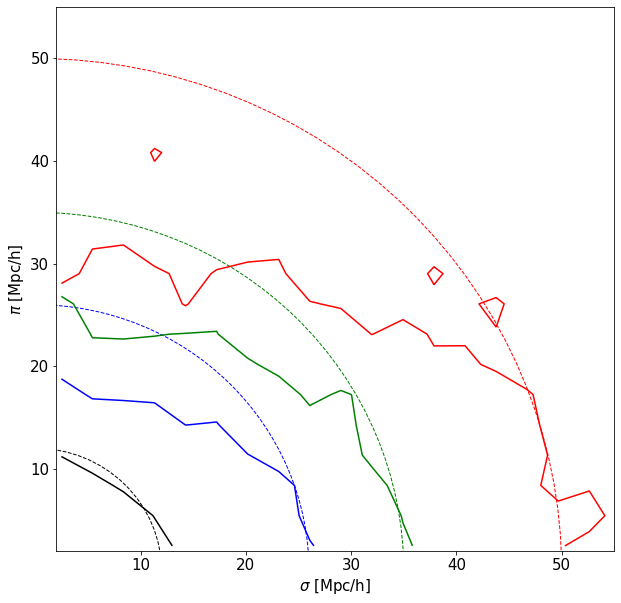

In [61]:
x=np.loadtxt("result.txt",skiprows=1)
sig=np.mean(x[:,0:2],axis=1).reshape((20,20)) 
pi=np.mean(x[:,2:4],axis=1).reshape((20,20))
xi=x[:,9].reshape((20,20)).transpose()

plt.figure(figsize=(10,10))

plt.contour(pi,sig,xi,levels=[0.04,0.1,0.2,0.7],colors=['r','g','b','k'])
plt.xlim((2,55))
plt.ylim((2,55))

#########################################################################
#### plotting circular contours to show the squashing effect in the data
circ1=plt.Circle((0,0),12,color='k', fill=False,linestyle='--')
circ2=plt.Circle((0,0),26,color='b', fill=False,linestyle='--')
circ3=plt.Circle((0,0),35,color='g', fill=False,linestyle='--')
circ4=plt.Circle((0,0),50,color='r', fill=False,linestyle='--')
ax = plt.gca()
ax.add_patch(circ1)
ax.add_patch(circ2)
ax.add_patch(circ3)
ax.add_patch(circ4)
#########################################################################
plt.xlabel(r'$\sigma$ [Mpc/h]')
plt.ylabel(r'$\pi$ [Mpc/h]')

### Anisotropic Analysis
Use the kaiser formula \\
$$ P^s_g(k,\mu)= P^r_m(k)( b_g +f\mu^2)^2$$

In [40]:
ff=1.1   # growth
bias=1.5 # galaxy bias

pk_ani=np.zeros((60,60))

for i in range(1,60):    #1->60 Mpc sigma-pi
  for j in range(1,60):
    rr=np.sqrt(i**2+j**2)
    mu=j/rr
    pk=pk_nonlin*(bias+ff*mu**2)**2
    pk_ani[i,j]=np.trapz(kh_nonlin**2*pk*np.sin(kh_nonlin*rr)/(kh_nonlin*rr),kh_nonlin)/(2*np.pi**2)

### Plot the theory and data together
Its a pretty good match!

Text(0, 0.5, '$\\pi$ [Mpc/h]')

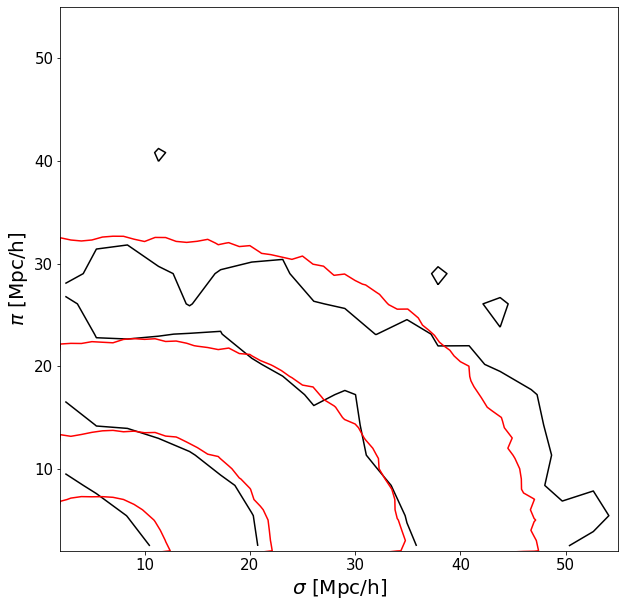

In [64]:
plt.figure(figsize=(10,10))
plt.contour(pi,sig,(xi),levels=[0.04, 0.1,0.3,1], colors='k')
plt.contour(range(1,61),range(1,61),(pk_ani),levels=[0.04, 0.1,0.3,1], colors='r')
plt.xlim((2,55))
plt.ylim((2,55))
plt.xlabel(r'$\sigma$ [Mpc/h]',fontsize=20)
plt.ylabel(r'$\pi$ [Mpc/h]',fontsize=20)

Adding the Alcock Paczynski Effect \\
$$\xi(\sigma,\pi) = \xi(\alpha_{\perp}\sigma_{fid},\alpha_{\parallel}\pi_{fid})$$ \\
$$\alpha_{\perp}=\frac{D_A(z)r_{d,\rm fid}}{D^{\rm fid}_A(z)r_{d}}, ~ \alpha_{\parallel}=\frac{H^{\rm fid}(z)r_{d,\rm fid}}{H(z)r_{d}}$$

In [41]:
ff=0.7       # growth
bias=1.8     # galaxy bias
alphapi=1.05
alphasigma=1.00

pk_ani2=np.zeros((60,60))

for i in range(1,60):    #1->60 Mpc sigma-pi
  for j in range(1,60):
    rr=np.sqrt((i*alphasigma)**2+(j*alphapi)**2)
    mu=(j*alphapi)/rr
    pk=pk_nonlin*(bias+ff*mu**2)**2
    pk_ani2[i,j]=np.trapz(kh_nonlin**2*pk*np.sin(kh_nonlin*rr)/(kh_nonlin*rr),kh_nonlin)/(2*np.pi**2)

Text(0, 0.5, '$\\pi$ [Mpc/h]')

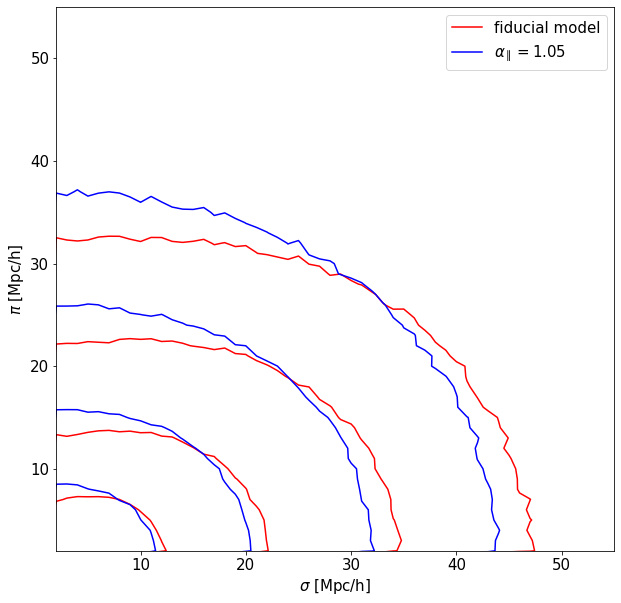

In [48]:
plt.figure(figsize=(10,10))
#plt.contour(pi,sig,(xi),levels=[0.04, 0.1,0.3,1], colors='k')
plt.contour(range(1,61),range(1,61),(pk_ani),levels=[0.04, 0.1,0.3,1], colors='r')
plt.contour(range(1,61),range(1,61),(pk_ani2),levels=[0.04, 0.1,0.3,1], colors='b')
plt.plot([-1,-1],[-1,-1],'r-',label='fiducial model')
plt.plot([-1,-1],[-1,-1],'b-',label=r'$\alpha_{\parallel}=1.05$')
plt.xlim((2,55))
plt.ylim((2,55))
plt.legend()
plt.xlabel(r'$\sigma$ [Mpc/h]')
plt.ylabel(r'$\pi$ [Mpc/h]')

## Large Scale and BAO
But lets make JK samples to compute errorbars

In [ ]:
!kstat/bin/jk.sh gal.txt ran.txt 5 3

Run code (~8mins)

In [67]:
!kstat/bin/2pcf -gal gal.txt.jk -ran ran.txt.jk -rmin 50.0 -rmax 125.0 -nbins 15 -wgt .true. -err 'read' -nerr 125

 Using weighted points.
  I will calculate the statistical covariance
  I will read the data for covariance
  Using          125  resamples for the statistical covariance.
 Preparing to read       213205 data points
 Preparing to read       214868 random points
 opening gal.txt.jk
 Finished reading data file 1
 opening ran.txt.jk
 Finished reading data file 2
 max resmaple:         125
 min resmaple:           1
  building tree on node           0
  built tree on node           0
 Calculating the isotropic 3D correlation function
   50.000000000000000        55.000000000000000     
   55.000000000000000        60.000000000000000     
   60.000000000000000        65.000000000000000     
   65.000000000000000        70.000000000000000     
   70.000000000000000        75.000000000000000     
   75.000000000000000        80.000000000000000     
   80.000000000000000        85.000000000000000     
   85.000000000000000        90.000000000000000     
   90.000000000000000        95.00000000

The isotropic BAO position is parameterised by the scale dilation
parameter $$\alpha=\frac{D_v(z)r_{d,\rm fid}}{D^{\rm fid}_v(z)r_{d}}$$

In [82]:
bias=2.3 #galaxy bias parameter

xi=[]
#rr=np.arange(10,200,10)
rr=np.arange(50,130,2)
alpha=1.06
for r in rr:

    xi.append(bias**2*np.trapz(kh_nonlin**2*pk_nonlin*np.sin(kh_nonlin*alpha*r)/(kh_nonlin*alpha*r),kh_nonlin)/(2*np.pi**2) + 0.002)

Text(0, 0.5, '$\\xi$')

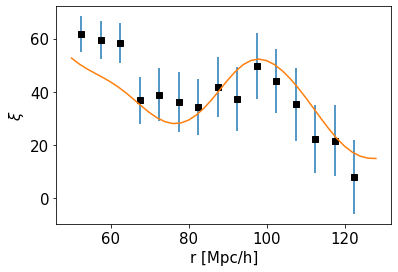

In [83]:
x=np.loadtxt('result.txt',skiprows=1)
r=np.mean(x[:,0:2],axis=1)
plt.errorbar(r,x[:,2]*r**2,yerr=x[:,3]*r**2,ls='none')
plt.plot(r,x[:,2]*r**2,'ks')
plt.plot(rr,xi*rr**2,'-')
plt.xlabel('r [Mpc/h]')
plt.ylabel(r'$\xi$')


In [ ]:
x=np.loadtxt("result.txt",skiprows=1)
plt.plot(rr,xi*rr*rr,'-')
plt.errorbar(np.mean(x[:,0:1],axis=1),x[:,7]*np.mean(x[:,0:1],axis=1)**2,yerr=0.1*x[:,7]*np.mean(x[:,0:1],axis=1)**2,marker='.',ls='none')

plt.xlabel('r [Mpc]',fontsize=20)
plt.ylabel(r'$\xi$',fontsize=20)

In [10]:
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)


1.7606816861659007

In [ ]:



def lnlike_BAOfs8(cube,Ass):
    omega_m, omega_b, h, sigma_8, n_s, mnu, Ab =  cube[0], cube[1], cube[4], cub
e[2],cube[3], cube[9], cube[6]

    pars = camb.CAMBparams()

    pars.set_cosmology(H0=h*100., ombh2=omega_b*h**2, omch2=(omega_m -omega_b)*h**2,omk=0.,tau=0.066)
    #pars.set_dark_energy(w=w0)

    pars.InitPower.set_params(As=1e-12,ns=n_s, r=0)
    pars.set_matter_power()
    results = camb.get_results(pars)
    sigma8=results.get_sigma8()
    #print(results.get_sigma8())
    desired_sigma8=sigma_8
    Ass=1e-12*desired_sigma8**2/sigma8**2
    if Ass>=2E-8:
        return -np.inf
    pars.InitPower.set_params(As=1e-12*desired_sigma8**2/sigma8**2,ns=n_s, r=0)

    pars.set_matter_power()

    camb.set_params(halofit_version='mead', HMCode_A_baryon=Ab, HMCode_eta_baryo
n=0.98-0.12*Ab)

    data = camb.CAMBdata()
    
    
    sixdFGS_inv_Dv = data.get_BAO(sixdFGS_z, pars)[0][0]
    sixdFGS_log_lik = - 0.5*(sixdFGS_inv_Dv_obs - sixdFGS_inv_Dv)**2/sixdFGS_inv
_Dv_cov
    
    sdss_dr7_inv_Dv = data.get_BAO(sdss_dr7_z, pars)[0][0]
    sdss_dr7_log_lik = - 0.5*(sdss_dr7_inv_Dv_obs - sdss_dr7_inv_Dv)**2/sdss_dr7
_inv_Dv_cov
    
    sdss_dr12_DA = data.angular_diameter_distance(sdss_dr12_z)
    sdss_dr12_DM = sdss_dr12_DA*(1.+sdss_dr12_z)
    sdss_dr12_H = data.hubble_parameter(sdss_dr12_z)
    
    pars.set_matter_power(redshifts=sdss_dr12_z_inv)
    results = camb.get_results(pars)
    sdss_dr12_fsigma8 = results.get_fsigma8()
    #print sdss_dr12_fsigma8
    
    sdss_dr12_diff = np.append(sdss_dr12_DM - sdss_dr12_DM_obs,[sdss_dr12_H - sd
ss_dr12_H_obs, sdss_dr12_fsigma8 -sdss_dr12_fsigma8_obs] )
    sdss_dr12_diff_log_lik = - 0.5*np.dot(sdss_dr12_diff,np.dot(sdss_dr12_icov,s
dss_dr12_diff))
    bao_log_likelihood = sixdFGS_log_lik+ sdss_dr7_log_lik + sdss_dr12_diff_log_
lik
    loglik = bao_log_likelihood[0]
    #print loglik
    if math.isnan(loglik):
        print('NaN')
        return -np.inf
    else:
        #print loglik
        return loglik


155.99382599495206


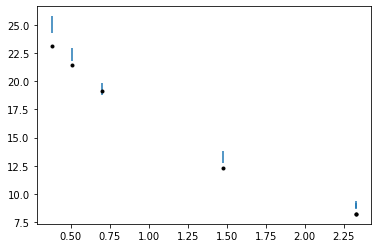

In [41]:
from astropy.cosmology import FlatwCDM
c=299792.458 #km/s

h=0.68
Om=0.3
Ob=0.04
w0=-1.0

cosmo = FlatwCDM(H0=h*100.0, Om0=Om, w0=w0)

############################################
#### load data
# copied data from https://www.sdss.org/science/final-bao-and-rsd-measurements/
DV_data=[4.47,18.33]
DV_err=[0.17,0.6]
DV_z=[0.15,0.85]

DM_data=np.asarray([10.23,13.36,17.86,30.69,37.6,37.3])
DM_err=np.asarray([0.17, 0.21, 0.21, 0.80, 1.9, 1.7])
DM_z=np.asarray([0.38,0.51,0.70,1.48,2.33,2.33])

DH_data=[25.00, 22.33, 19.33, 13.26, 8.93, 9.08]
DH_err=[ 0.76, 0.58,  0.53, 0.55, 0.28,0.34]
DH_z=[0.38,0.51,0.70,1.48,2.33,2.33]
############################################

## sound horizon approx from Eq 12 of arxiv:0907.1660    
rs=153.5*((Ob*h*h/0.02273)**-0.134)*((Om*h*h/0.1326)**-0.255)
rfid=147.78

#zs=np.array([0.106,0.15,0.38,0.51,0.61,0.978,1.23,1.526,1.944])
H0=c/cosmo.H(DH_z).value

DM=cosmo.comoving_distance(DM_z).value

#DV=(zs*3E5*DM**2/H0)**0.3333 / (rs)
DA=(DM/(1.0+DM_z))*rs/rfid
H0rs=H0*(rfid/rs)
DMrs=DM*(rs/rfid)

#plt.errorbar(DM_z,DM_data,yerr=DM_err,ls='none')
#plt.plot(DM_z,DM/rs,'k.')

plt.errorbar(DH_z,DH_data,yerr=DH_err,ls='none')
plt.plot(DH_z,H0/rs,'k.')

print(rs)
#lowz_model=[DV[0],DV[1]]
#lowz_data=[3.047,4.480]
#lowz_err=[0.137,0.168]
#lowz_chi=-0.5*np.sum(np.subtract(lowz_data,lowz_model)**2/(np.power(lowz_err,2.)))
    
#dr12_model=[DMrs[2],H0rs[2],DMrs[3],H0rs[3],DMrs[4],H0rs[4]]
#dr12_chi=-0.5*np.dot(np.dot(np.transpose((dr12_data-dr12_model)),dr12_cov),(dr12_data-dr12_model))

#dr14_model=[DA[5],H0rs[5],DA[6],H0rs[6],DA[7],H0rs[7],DA[8],H0rs[8]]
#dr14_chi=-0.5*np.dot(np.dot(np.transpose((dr14_data-dr14_model)),dr14_cov),(dr14_data-dr14_model))

#print("BAO Like: ",lowz_chi+dr14_chi+dr12_chi)


In [ ]:
def load_BAO():
	dr12_data=np.loadtxt("dr12_data.txt")
	dr12_data=dr12_data[:,1]
	dr12_cov=np.loadtxt("dr12_cov.txt")
	dr12_cov=np.linalg.pinv(dr12_cov)
	##BOSS DR12 sample

	dr14_data=np.loadtxt("dr14_data.txt")
	dr14_data=dr14_data[:,1]
	dr14_cov=np.loadtxt("dr14_cov.txt")
	dr14_cov=np.linalg.pinv(dr14_cov)
	##eBOSS DR14 sample arXiv: 1801.03043. See Table 2
	return dr12_data,dr12_cov,dr14_data,dr14_cov
